In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
from tensorflow.keras import layers
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import random
import sys
import cv2
import os

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d eeshawn/flickr30k --unzip

100% 4.08G/4.08G [00:52<00:00, 129MB/s]
100% 4.08G/4.08G [00:52<00:00, 83.3MB/s]


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8b465081-51de-e3cf-3367-4da91caa3fa8)


In [4]:
BASE_DIR = '/content/flickr30k_images'

In [26]:
feature_exe = tf.keras.applications.resnet_v2.ResNet152V2(
    include_top=True,
    weights='imagenet',
    input_shape=(224,224,3),
)
feature_exe.trainable = False

feature_exe = Model(inputs=feature_exe.inputs, outputs=feature_exe.layers[-2].output)

242745792/242745792 [==============================] - 5s 0us/step


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.530941 to fit



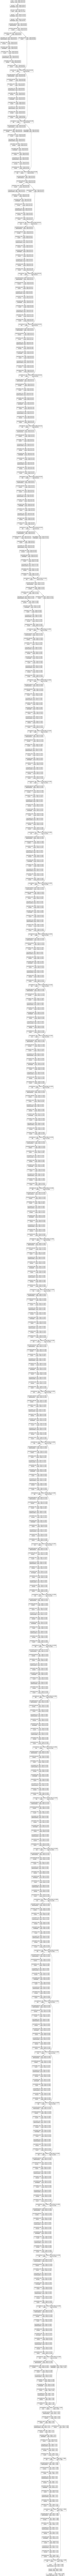

In [32]:
plot_model(feature_exe, show_shapes=True)

In [ ]:
features = dict()

for img_name in tqdm(os.listdir(BASE_DIR)):
    img_path = os.path.join(BASE_DIR,img_name)
    image = load_img(img_path, target_size = (224,224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    # image = tf.keras.applications.resnet_v2.preprocess_input(image)
    image = preprocess_input(image)
    feature = feature_exe.predict(image,verbose = False)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/31783 [00:00<?, ?it/s]

In [ ]:
print(sys.getsizeof(features))

1310808


In [6]:
features['1000092795']

array([[0.05533108, 0.3065802 , 0.        , ..., 0.23009607, 0.17496851,
        0.30537084]], dtype=float32)

In [ ]:
with open(os.path.join('/content','captions.txt'),'r') as file:
    next(file)
    captions_doc = file.read()
    
mapping = dict()

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0],tokens[2:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
clean(mapping)

In [ ]:
mapping['10010052']

['startseq girl is on rollerskates talking on her cellphone standing in parking lot endseq',
 'startseq trendy girl talking on her cellphone while gliding slowly down the street endseq',
 'startseq young adult wearing rollerblades holding cellular phone to her ear endseq',
 'startseq there is young girl on her cellphone while skating endseq',
 'startseq woman talking on cellphone and wearing rollerskates endseq']

In [9]:
processed_captions = list()

for key in mapping:
    for caption in mapping[key]:
        processed_captions.append(caption)
        
print('Total No. of Captions', len(processed_captions))

Total No. of Captions 158915


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_captions)
vocab_size = len(tokenizer.word_index)+1

print('Number of unique words in all captions is ',vocab_size )

Number of unique words in all captions is  18319


In [10]:
max_length = max(len(caption.split()) for caption in processed_captions)
print('The Longest caption of whole corpus is',max_length, 'word long')

The Longest caption of whole corpus is 74 word long


In [11]:
images_ids = list(mapping.keys())
split = int(len(images_ids) * 0.90)
train = images_ids[:split]
test = images_ids[split:]
print('Train length', len(train))
print( 'Test length', len(test))

Train length 28604
Test length 3179


#### Had memory issues in this generator

In [ ]:
def data_gen(data_keys, mapping, features, tokenizer, max_length, vocab_size,batch_size):
    
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq,out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen= max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)

            if n== batch_size:
                x1 = np.array(x1)
                x2 = np.array(x2)
                y = np.array(y)
                yield [x1,x2],y
                x1, x2, y = list(), list(), list()
                n= 0

#### So i used this

In [12]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    
    def encode_and_pad(caption):
        
        seq = tokenizer.texts_to_sequences([caption])[0]
        
        X, y = [], []
        for i in range(1, len(seq)):
            
            in_seq, out_seq = seq[:i], seq[i]
            
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
           
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            X.append(in_seq)
            y.append(out_seq)
        return X, y
    
    def generator():
        while True:
            for key in data_keys:
                captions = mapping[key]
                for caption in captions:
                    X, y = encode_and_pad(caption)
                    for i in range(len(X)):
                        yield (features[key][0], X[i]), y[i]
                        
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=((tf.float32, tf.int32), tf.int32),
        output_shapes=((features[data_keys[0]][0].shape, (max_length,)), (vocab_size,))
    )
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 74, 256)      4689664     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

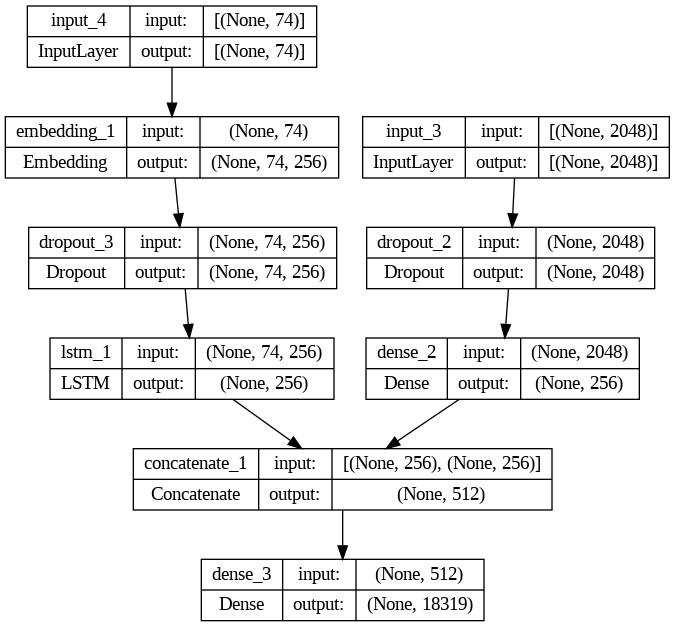

In [ ]:
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.models import Model
from keras.utils import to_categorical

# Define the input shapes
image_input_shape = (2048,)
caption_input_shape = (74,)

# Define the hyperparameters
vocab_size = 18319
embedding_dim = 256
hidden_dim = 256
dropout_rate = 0.4

# Define the image encoder
image_input = Input(shape=image_input_shape)
image_encoder = Dropout(dropout_rate)(image_input)
image_encoder = Dense(hidden_dim, activation='relu',kernel_regularizer=regularizers.l2(0.01))(image_encoder)

# Define the caption decoder
caption_input = Input(shape=caption_input_shape)
caption_encoder = Embedding(vocab_size, embedding_dim, mask_zero=True)(caption_input)
caption_encoder = Dropout(dropout_rate)(caption_encoder)
caption_encoder = LSTM(hidden_dim,kernel_regularizer=regularizers.l2(0.01))(caption_encoder)

# Concatenate the image and caption encodings
merged = keras.layers.concatenate([image_encoder, caption_encoder])

# Define the output layer
output = Dense(vocab_size, activation='softmax')(merged)

# Define the model
model = Model(inputs=[image_input, caption_input], outputs=output)

# Print the model summary
model.summary()
plot_model(model, show_shapes = True)

In [ ]:
epochs = 20
batch_size = 64
steps = len(train) // batch_size
val_steps = len(test)// batch_size
num_warmup_steps = steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)
model.compile(loss= 'categorical_crossentropy', optimizer=keras.optimizers.Adam(lr_schedule))

In [ ]:

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    test_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator,
              epochs=1, 
              steps_per_epoch=steps, 
              verbose=1, 
              validation_data = test_generator,
              validation_steps=val_steps,
              callbacks=[early_stopping])
    model.save_weights('model_weights.h5')  
    print('Weights saved after epoch', i)
    
    if i < epochs - 1:
        keras.backend.clear_session()
        tf.compat.v1.reset_default_graph()
        print('session cleared')
        model.load_weights('model_weights.h5')
        print('Weights loaded for epoch', i+1)
    
    # Free up memory
    del generator
    del test_generator

446/446 [==============================] - 125s 257ms/step - loss: 11.3694 - val_loss: 7.7784
Weights saved after epoch 0
session cleared
Weights loaded for epoch 1
446/446 [==============================] - 110s 244ms/step - loss: 6.4693 - val_loss: 6.8101
Weights saved after epoch 1
session cleared
Weights loaded for epoch 2
446/446 [==============================] - 108s 240ms/step - loss: 5.9296 - val_loss: 6.7437
Weights saved after epoch 2
session cleared
Weights loaded for epoch 3
446/446 [==============================] - 108s 239ms/step - loss: 5.7878 - val_loss: 6.7386
Weights saved after epoch 3
session cleared
Weights loaded for epoch 4
446/446 [==============================] - 109s 241ms/step - loss: 5.7033 - val_loss: 6.7416
Weights saved after epoch 4
session cleared
Weights loaded for epoch 5
446/446 [==============================] - 110s 244ms/step - loss: 5.6453 - val_loss: 6.7599
Weights saved after epoch 5
session cleared
Weights loaded for epoch 6
446/446 [======

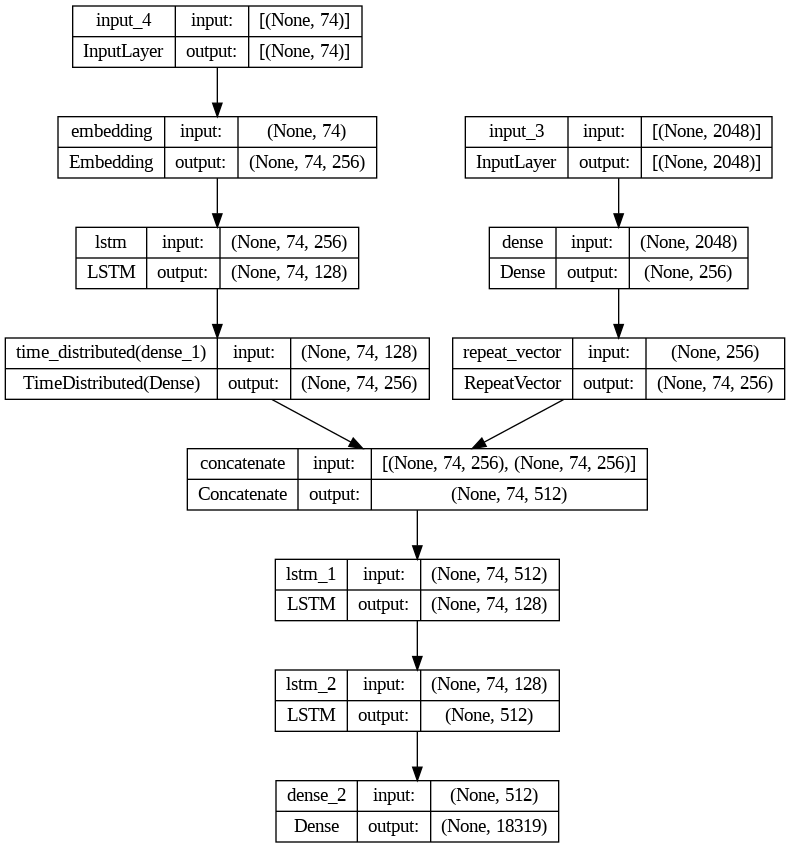

In [ ]:
input1 = Input(shape=(2048,))
image_encoder1 = Dense(256, activation = 'relu')(input1)
image_encoder2 = RepeatVector(max_length)(image_encoder1)

input2 = Input(shape = (max_length,))
text_encoder1 = Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length)(input2)
text_encoder2 = LSTM(128, return_sequences=True)(text_encoder1)
setext_encoder3 = TimeDistributed(Dense(256))(text_encoder2)

conca = Concatenate()([image_encoder2, setext_encoder3])

decoder1 = LSTM(128, return_sequences=True)(conca)
decoder2 = LSTM(512, return_sequences=False)(decoder1)
decoder3 = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[[input1,input2]], outputs = decoder3)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 256)      4689664     ['input_4[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['input_3[0][0]']                
                                                                                            

## Made Predictions with this Model

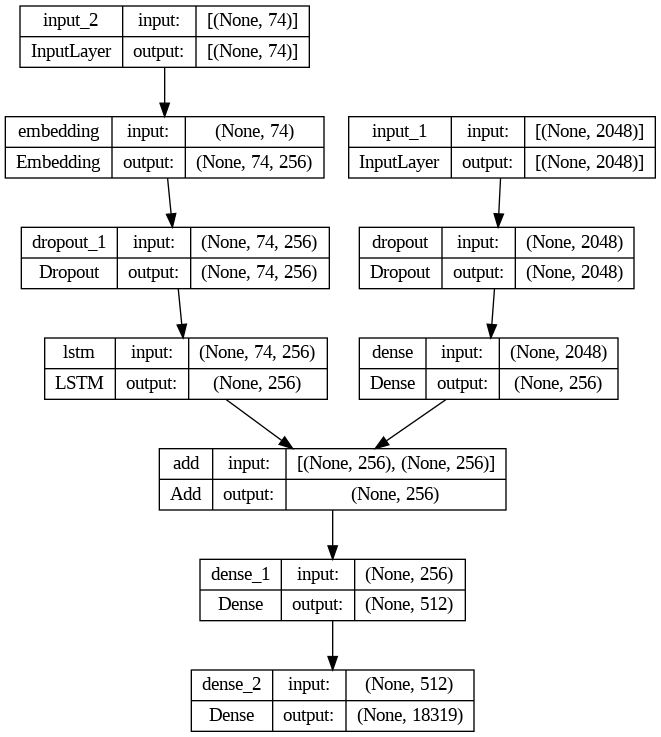

In [ ]:

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01))(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256,kernel_regularizer=regularizers.l2(0.01))(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 256)      4689664     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

#### Model is poorly Overfitted

In [ ]:
epochs = 10
batch_size = 64
steps = len(train) // batch_size
val_steps = len(test)// batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    test_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator,
              epochs=1, 
              steps_per_epoch=steps, 
              verbose=1, 
              validation_data = test_generator,
              validation_steps=val_steps)
    model.save_weights('model_weights.h5')  
    print('Weights saved after epoch', i)
    
    if i < epochs - 1:
        keras.backend.clear_session()
        tf.compat.v1.reset_default_graph()
        print('session cleared')
        model.load_weights('model_weights.h5')
        print('Weights loaded for epoch', i+1)
    
    # Free up memory
    del generator
    del test_generator

446/446 [==============================] - 107s 241ms/step - loss: 3.9920 - val_loss: 8.0571
Weights saved after epoch 0
session cleared
Weights loaded for epoch 1
446/446 [==============================] - 110s 245ms/step - loss: 3.9632 - val_loss: 8.3469
Weights saved after epoch 1
session cleared
Weights loaded for epoch 2
446/446 [==============================] - 108s 239ms/step - loss: 3.8498 - val_loss: 8.6701
Weights saved after epoch 2
session cleared
Weights loaded for epoch 3
446/446 [==============================] - 105s 234ms/step - loss: 3.8108 - val_loss: 8.8467
Weights saved after epoch 3
session cleared
Weights loaded for epoch 4
446/446 [==============================] - 104s 229ms/step - loss: 3.7629 - val_loss: 8.7521
Weights saved after epoch 4
session cleared
Weights loaded for epoch 5
446/446 [==============================] - 104s 230ms/step - loss: 3.7357 - val_loss: 8.2467
Weights saved after epoch 5
session cleared
Weights loaded for epoch 6
446/446 [=======

In [ ]:
model.save('/content/drive/MyDrive/Image Caption Work/less_model.h5')

In [14]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Image Caption Work/model.h5')

In [15]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [16]:
def predict_caption(key):
  in_text = 'startseq'
  for i in range(max_length):
     
      sequence = tokenizer.texts_to_sequences([in_text])[0]
      
      sequence = pad_sequences([sequence], maxlen=max_length)
      
      yhat = model.predict([features[key], sequence], verbose=0)
      
      yhat = np.argmax(yhat)
      word = word_for_id(yhat, tokenizer)
      
      if word is None:
          break
      
      in_text += ' ' + word
      
      if word == 'endseq':
          break

  return in_text

In [ ]:
actual, predicted = list(), list()

for key in tqdm(test[:2700]):
    captions = mapping[key]
    y_pred = predict_caption(key)
    actual_caption = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_caption)
    predicted.append(y_pred)

  0%|          | 0/2700 [00:00<?, ?it/s]

In [ ]:
#At loss 0.3
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.423437
BLEU-2: 0.168477
BLEU-3: 0.033779


In [17]:
def test_captioin(img_id):
  image_name = str(img_id)+'.jpg'
  image_path = os.path.join(BASE_DIR,image_name)
  image = Image.open(image_path)
  captions = mapping[str(img_id)]
  y_pred = predict_caption(str(img_id))
  print('----------------------------------')
  print('------------Actual----------------')
  print('----------------------------------')
  for i in captions:
      print(i)
  print('---------------------------------')
  print('----------Predicted--------------')
  print('---------------------------------')
  print(y_pred)
  plt.axis('off')
  plt.imshow(image)

----------------------------------
------------Actual----------------
----------------------------------
startseq small girl wearing white and multi-print dress sitting at the bottom of slide endseq
startseq little girl in white sundress smiles and slides down blue slide endseq
startseq the girl in the white dress is going down the blue slide endseq
startseq little girl on blue slide at playground endseq
startseq young girl is at the bottom of slide endseq
---------------------------------
----------Predicted--------------
---------------------------------
startseq man in blue shirt and blue shirt is standing on the ground endseq


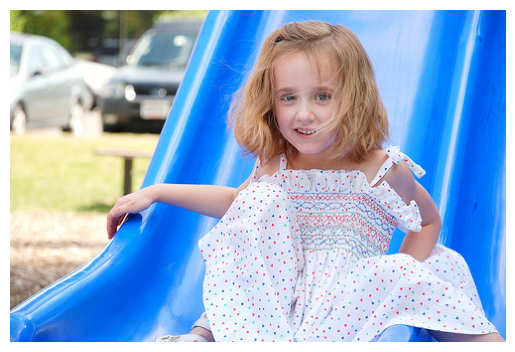

In [ ]:
test_captioin(test[90])

----------------------------------
------------Actual----------------
----------------------------------
startseq mariachi band is playing in someone 's yard but only three players are visible endseq
startseq mariachi musicians perform outdoors on guitars and trumpet endseq
startseq mexican mariachi band with the guitarist up front endseq
startseq three mariachi band members play in grass yard endseq
startseq group of three men play mariachi music endseq
---------------------------------
----------Predicted--------------
---------------------------------
startseq man wearing black shirt plays guitar as they playing sheet with an other musicians endseq


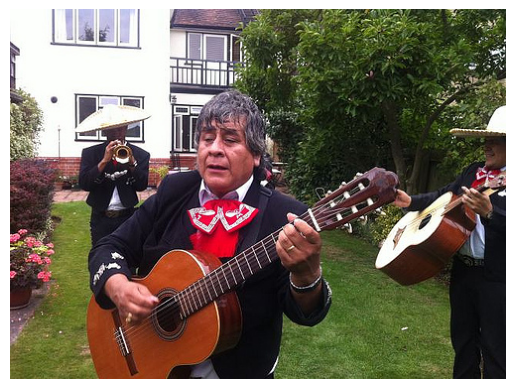

In [19]:
test_captioin(test[112])

----------------------------------
------------Actual----------------
----------------------------------
startseq three dogs on beach looking at red ball in someones hand endseq
startseq three dogs look as human holds pink ball on the beach endseq
startseq pink ball is being held up before three dogs on beach endseq
startseq three dogs stare curiously at chewed up toy endseq
startseq three dogs stare at red ball at the beach endseq
---------------------------------
----------Predicted--------------
---------------------------------
startseq the two are is standing in the grass endseq


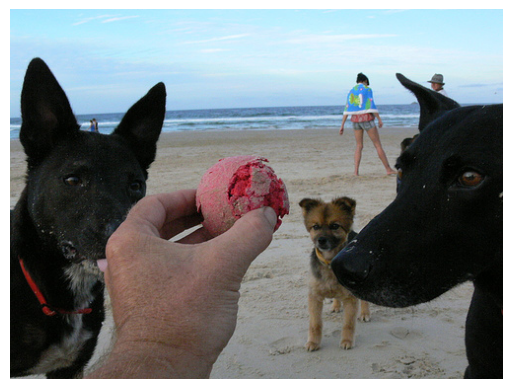

In [18]:
test_captioin(test[56])

----------------------------------
------------Actual----------------
----------------------------------
startseq young brunette figure skater photographed in mid twirl in her white skaters outfit endseq
startseq figure skater in pale blue costume strikes pose on the ice endseq
startseq figure skater works on her skating routine endseq
startseq young woman skates on ice endseq
startseq woman ice skating on ice endseq
---------------------------------
----------Predicted--------------
---------------------------------
startseq girl playing the trumpet outside very his hands endseq


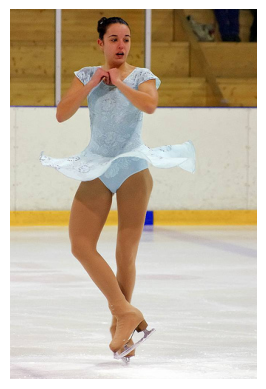

In [20]:
test_captioin(test[445])

----------------------------------
------------Actual----------------
----------------------------------
startseq competitive rower is rowing through the water while wearing sunglasses to protect his eyes from the sun endseq
startseq man dressed in athletic gear and sunglasses sits in boat paddling with large oar endseq
startseq young man with brown hair wearing green outfit is rowing with an oar endseq
startseq muscular young man donning sunglasses rows one oar of rowboat endseq
startseq man in sunglasses is rowing boat of some kind endseq
---------------------------------
----------Predicted--------------
---------------------------------
startseq two people play with blue and orange shoes on endseq


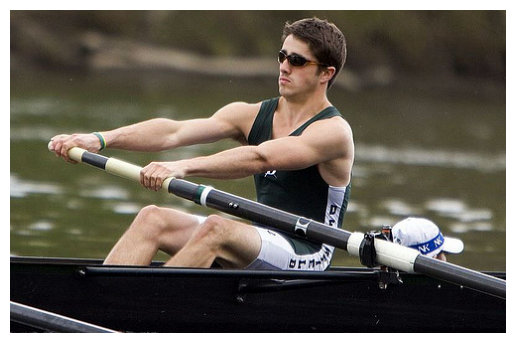

In [21]:
test_captioin(test[67])

In [28]:
def new_image_caption(path):
    shw = Image.open(path)
    image = load_img(path, target_size = (224,224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    feature = feature_exe.predict(image,verbose = False)

    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    text = in_text.replace('startseq ', '').replace(' endseq', '')
    print('Caption: ',text)
    plt.axis('off')
    plt.imshow(shw)

Caption:  young boy does handstand in the air at lake


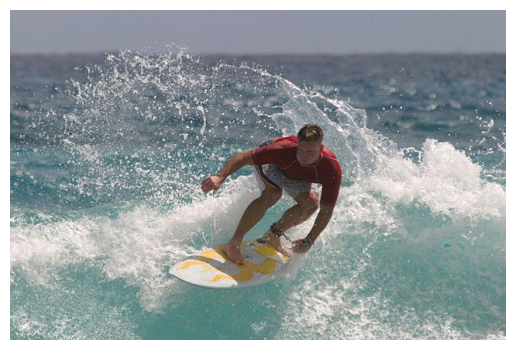

In [29]:
new_image_caption('/content/surf.jpg')

Caption:  two large dog are running through the lawn


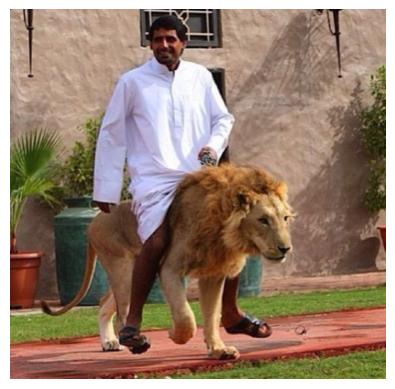

In [30]:
new_image_caption('/content/riding-a-lion-dubai.jpg')